<a href="https://colab.research.google.com/github/filmerxyz/JSTP-22_SkinDiseaseClassificationUsingMachineLearning/blob/master/Accumulate_InceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Mon May 25 17:07:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install Run:AI Gradient Accumulation library
https://github.com/run-ai/runai/tree/master/runai/ga

In [2]:
!pip install runai

# Import Libraries

In [3]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [4]:
import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

import keras
from keras import backend as K
from keras import optimizers
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.legacy import interfaces
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import runai.ga.keras

from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

from ham10000_utils_functions import plot_confusion_matrix, normalize, deprocess_image, my_decode_predictions, guided_backprop, grad_cam, compute_saliency

Using TensorFlow backend.


# Hyperparameters

In [0]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

BATCH_SIZE = 16
STEPS = 16
LR = 1e-3
EPOCHS = 100

# Data Preparation

In [6]:
!git clone https://github.com/EvilPickle-PCSHSPT/ham10000-with-one-image-folder

Cloning into 'ham10000-with-one-image-folder'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10045 (delta 4), reused 7 (delta 2), pack-reused 10036
Receiving objects: 100% (10045/10045), 2.57 GiB | 15.39 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Checking out files: 100% (10022/10022), done.


In [0]:
metadata_path = '/content/ham10000-with-one-image-folder/HAM10000_metadata.csv'
img_path = '/content/ham10000-with-one-image-folder/HAM1000_images'

In [0]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [0]:
data = pd.read_csv(metadata_path)

In [0]:
num_examples = data.values.shape[0]

In [0]:
inputs = np.empty(shape=(num_examples, IMG_WIDTH, IMG_HEIGHT, 3), dtype=np.float32)
labels = np.empty(shape=(num_examples), dtype=np.uint8)

### Resize to 224*224

In [0]:
for i, row in enumerate(data.values):
    img_id = row[1]
    label = row[2]
    all_img_path = os.path.join(img_path, img_id) + '.jpg' 
    if (os.path.isfile(all_img_path)):
        im_path = all_img_path
    else:
        raise Exception ('File not found \'%s\'' %img_id)
    img = Image.open(im_path).resize((IMG_WIDTH, IMG_HEIGHT), Image.LANCZOS)
    inputs[i] = np.array(img)/255.0
    labels[i] = label_names.index(label)

### Split Data

In [0]:
x_train, x_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.1, random_state=555)

del inputs
del labels

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=555)

In [14]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6309, 224, 224, 3) (6309,)
(2704, 224, 224, 3) (2704,)
(1002, 224, 224, 3) (1002,)


### Data Augmentation

In [0]:
datagen = ImageDataGenerator(
        rotation_range=360,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')

In [0]:
datagen.fit(x_train)

# Adam Accumulate

In [17]:
ga_optimizer = runai.ga.keras.optimizers.Optimizer(Adam(LR), steps=STEPS)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[Run:AI] [DEBUG   ] [25-05-2020 17:13:48.836] [137] [optimizers.py          :16  ] Wrapping 'Adam' Keras optimizer with GA of 16 steps


# Build Model
InceptionV3 + fine tuning

In [0]:
def build_model():
  base_model = InceptionV3(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  
  for layer in base_model.layers[:172]:
    layer.trainable = False
  for layer in base_model.layers[172:]:
    layer.trainable = True

  average_pooling_layer = GlobalAveragePooling2D()(base_model.output)
  fc_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.00001))(average_pooling_layer)
  fc_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.00001))(fc_layer)
  bn_layer = BatchNormalization()(fc_layer)
  dropout_layer = Dropout(0.25)(bn_layer)
  prediction_layer = Dense(units=7, activation='softmax', name='prediction')(dropout_layer)
  model = Model(inputs=base_model.input, outputs=prediction_layer)

  model.compile(optimizer=ga_optimizer, 
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [19]:
model = build_model()



87916544/87910968 [==============================] - 7s 0us/step


In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Callbacks

In [0]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='acc_inceptionv3_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-5 , patience=10, verbose=1, min_delta=1e-4, mode='min')

### Training

In [22]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                              validation_data=(x_val, y_val, compute_sample_weight('balanced', y_val)),
                              class_weight=compute_class_weight('balanced', np.unique(y_train), y_train),
                              steps_per_epoch=math.ceil(x_train.shape[0]/BATCH_SIZE),
                              epochs=EPOCHS,
                              callbacks=[early_stop, model_checkpoint, reduce_lr_rate])


Epoch 1/100
395/395 [==============================] - 78s 197ms/step - loss: 1.5704 - accuracy: 0.5552 - val_loss: 2.8256 - val_accuracy: 0.6701
Epoch 2/100
395/395 [==============================] - 64s 161ms/step - loss: 1.1415 - accuracy: 0.7066 - val_loss: 2.8453 - val_accuracy: 0.6882
Epoch 3/100
395/395 [==============================] - 64s 161ms/step - loss: 0.9971 - accuracy: 0.7383 - val_loss: 3.0777 - val_accuracy: 0.6886
Epoch 4/100
395/395 [==============================] - 64s 161ms/step - loss: 0.8890 - accuracy: 0.7559 - val_loss: 2.7954 - val_accuracy: 0.6912
Epoch 5/100
395/395 [==============================] - 64s 162ms/step - loss: 0.7984 - accuracy: 0.7730 - val_loss: 2.8561 - val_accuracy: 0.6905
Epoch 6/100
395/395 [==============================] - 64s 163ms/step - loss: 0.7583 - accuracy: 0.7787 - val_loss: 2.2578 - val_accuracy: 0.6893
Epoch 7/100
395/395 [==============================] - 64s 163ms/step - loss: 0.7068 - accuracy: 0.7879 - val_loss: 3.0387 

# Graph

### Accuracy

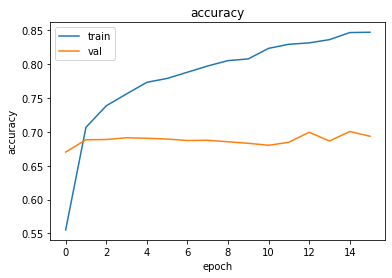

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

### Loss

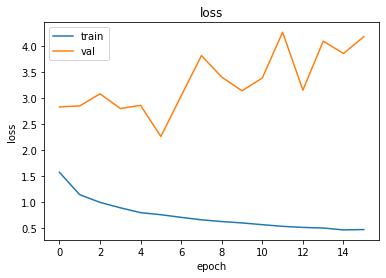

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluate

In [0]:
test_model = load_model('/content/acc_inceptionv3_model.h5', compile=False)

In [28]:
y_pred = np.argmax(test_model.predict(x_test), axis=1)
print('balanced acc on test set:', balanced_accuracy_score(y_true=y_test, y_pred=y_pred))

balanced acc on test set: 0.30595063745317513


### Classification Report

In [29]:
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=label_names)
print(report)

              precision    recall  f1-score   support

       akiec       0.75      0.09      0.16        33
         bcc       0.36      0.22      0.27        41
         bkl       0.67      0.02      0.04        99
          df       0.09      0.62      0.15        13
         mel       0.00      0.00      0.00       118
          nv       0.75      0.96      0.84       681
        vasc       1.00      0.24      0.38        17

    accuracy                           0.68      1002
   macro avg       0.52      0.31      0.26      1002
weighted avg       0.63      0.68      0.60      1002



### Confusion Matrix

Confusion matrix, without normalization
[[  3   5   0  11   0  14   0]
 [  0   9   0   9   0  23   0]
 [  0   6   2  16   0  75   0]
 [  0   0   0   8   0   5   0]
 [  1   3   1  19   0  94   0]
 [  0   1   0  26   0 654   0]
 [  0   1   0   2   1   9   4]]


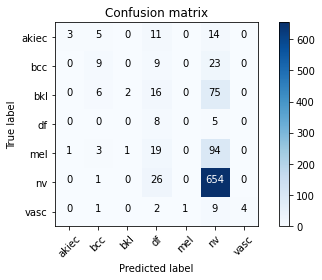

In [30]:
cm = (confusion_matrix(y_true=y_test, y_pred=y_pred))

plot_confusion_matrix(cm, label_names)

### Sensitivity & Specificity

In [0]:
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

In [32]:
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

sensitivity: 0.3750
specificity: 1.0000


# Grad-CAM

In [0]:
last_conv2d = 'conv2d_94'

### AKIEC

In [0]:
akiec_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0026492.jpg'

Model prediction:
	nv             	(5)	with probability 0.727
	df             	(3)	with probability 0.112
	vasc           	(6)	with probability 0.063
	bcc            	(1)	with probability 0.046
	akiec          	(0)	with probability 0.039
Explanation for 'nv'


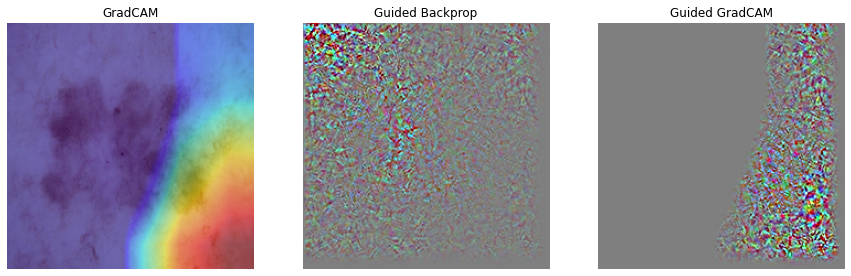

In [38]:
radcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

### BCC

In [0]:
bcc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024332.jpg'

Model prediction:
	nv             	(5)	with probability 0.994
	df             	(3)	with probability 0.002
	bcc            	(1)	with probability 0.002
	akiec          	(0)	with probability 0.002
	vasc           	(6)	with probability 0.001
Explanation for 'nv'


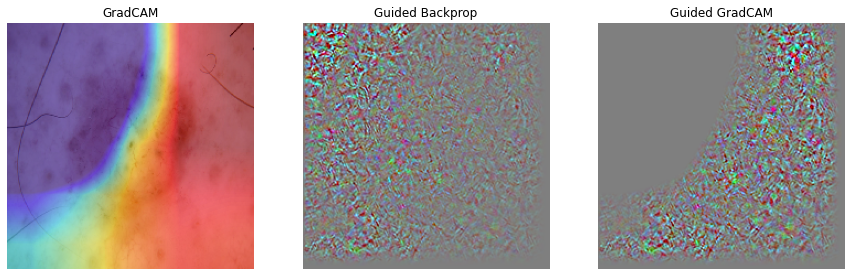

In [40]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bcc_img, layer_name=last_conv2d)

In [0]:
bkl_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025548.jpg'

Model prediction:
	nv             	(5)	with probability 0.989
	mel            	(4)	with probability 0.005
	df             	(3)	with probability 0.003
	akiec          	(0)	with probability 0.001
	vasc           	(6)	with probability 0.001
Explanation for 'nv'


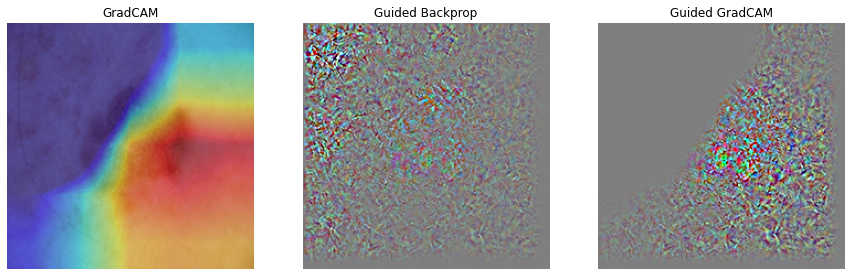

In [42]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, bkl_img, layer_name=last_conv2d)

### DF

In [0]:
df_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0033626.jpg'

Model prediction:
	df             	(3)	with probability 0.699
	nv             	(5)	with probability 0.267
	akiec          	(0)	with probability 0.017
	vasc           	(6)	with probability 0.010
	mel            	(4)	with probability 0.003
Explanation for 'df'


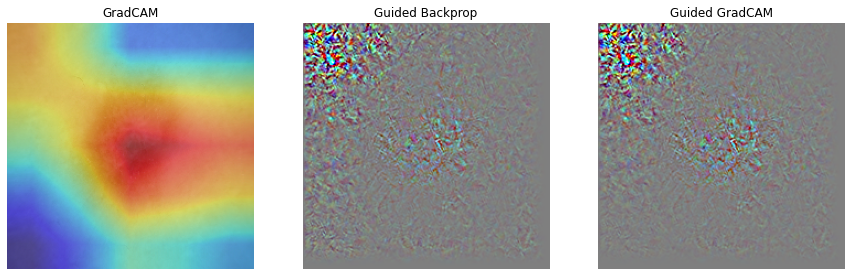

In [44]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, df_img, layer_name=last_conv2d)

### MEL

In [0]:
mel_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024516.jpg'

Model prediction:
	nv             	(5)	with probability 0.998
	df             	(3)	with probability 0.001
	akiec          	(0)	with probability 0.000
	vasc           	(6)	with probability 0.000
	mel            	(4)	with probability 0.000
Explanation for 'nv'


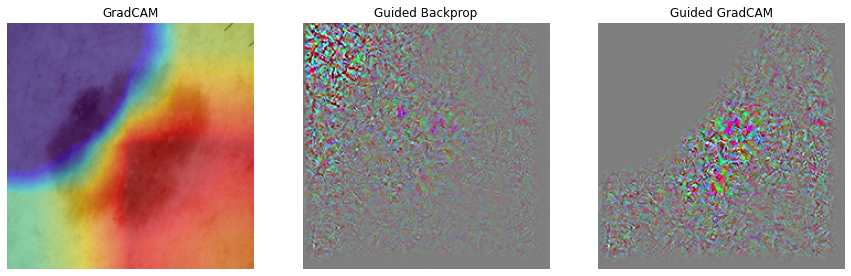

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, mel_img, layer_name=last_conv2d)

### NV

In [0]:
nv_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0024349.jpg'

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, nv_img, layer_name=last_conv2d)

### VASC

In [0]:
vasc_img = '/content/ham10000-with-one-image-folder/HAM1000_images/ISIC_0025452.jpg'

In [0]:
gradcam, gb, guided_gradcam = compute_saliency(model, model, vasc_img, layer_name=last_conv2d)

# Download Model

In [0]:
from google.colab import files

In [0]:
# files.download('/content/acc_densenet121_model.h5')